<a href="https://colab.research.google.com/github/meekrob/kras-exercise/blob/main/KRAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyze ctDNA sample for variants in target gene

## Plan

1. Install required software, as specified by provided reference.
2. Download sequence data
2. Filter and Align specified fastq file
3. Call variants with gatk/varscan pipeline,
4. Assess mutations in KRAS gene



## 1. Install and verify tools

In [ ]:
!apt-get update
# there are issues with linked library files but the execs seem to run
!apt-get install fastp bwa samtools sra-toolkit

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://cli.github.com/packages stable InRelease [3,917 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 https://cli.github.com/packages stable/main amd64 Packages [343 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,143 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,457 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu j

In [ ]:
# gatk 4
!wget https://github.com/broadinstitute/gatk/releases/download/4.6.2.0/gatk-4.6.2.0.zip
!unzip gatk-4.6.2.0.zip
!mkdir -p sw && mv -v gatk-4.6.2.0 sw
!ln -sv /content/sw/gatk-4.6.2.0/gatk /content/sw/gatk

# picard
!wget https://github.com/broadinstitute/picard/releases/download/3.4.0/picard.jar
!mv -v picard.jar sw

# Varscan 2
!cd sw && wget https://github.com/dkoboldt/varscan/releases/download/v2.4.6/VarScan.v2.4.6.jar
!ln -sv /content/sw/VarScan.v2.4.6.jar /content/sw/varscan.jar

## Download genome and create index

If you have genome files and indexes stored, link them in the code chunk below, otherwise, create a local hg19 directory.

Using hg19 assembly from UCSC.

Checking integrity with md5sum.  The checksums are at https://hgdownload.gi.ucsc.edu/goldenPath/hg19/chromosomes/md5sum.txt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ln -s /content/drive/MyDrive/hg19 .

# mkdir hg19

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Use the hg19 genome assembly, as used by the authors in the provided reference.

In [ ]:
!wget --timestamping http://hgdownload.cse.ucsc.edu/goldenPath/hg19/bigZips/hg19.fa.gz

!chk=($(md5sum hg19.fa.gz)) && [ "806c02398f5ac5da8ffd6da2d1d5d1a9" == ${chk[0]} ] && echo "Download OK" || "checksum failed. Verify download."
![ -e hg19.fa.gz ] && gunzip -v hg19.fa.gz

!mv -v hg19.fa hg19

--2025-11-15 16:31:36--  http://hgdownload.cse.ucsc.edu/goldenPath/hg19/bigZips/hg19.fa.gz
Resolving hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 948731419 (905M) [application/x-gzip]
Saving to: ‘hg19.fa.gz’

hg19.fa.gz          100%[===================>] 904.78M  21.4MB/s    in 44s     

2025-11-15 16:32:21 (20.5 MB/s) - ‘hg19.fa.gz’ saved [948731419/948731419]

Download OK
hg19.fa.gz:	 70.4% -- replaced with hg19.fa
mkdir: created directory 'hg19'
renamed 'hg19.fa' -> 'hg19/hg19.fa'


### BWA index

Indexing of the target sequence using the Burrows Wheeler transform provides a dynamic programming solution to alignment.

Although chromosome 12 contains the gene of interest. The whole genome helps GATK in error modeling procedures.

In [11]:
!cd hg19 && bwa index hg19.fa

[bwa_index] Pack FASTA... 17.91 sec
[bwa_index] Construct BWT for the packed sequence...
[BWTIncCreate] textLength=6274322528, availableWord=453484340
[BWTIncConstructFromPacked] 10 iterations done. 100000000 characters processed.
[BWTIncConstructFromPacked] 20 iterations done. 200000000 characters processed.
[BWTIncConstructFromPacked] 30 iterations done. 300000000 characters processed.
[BWTIncConstructFromPacked] 40 iterations done. 400000000 characters processed.
[BWTIncConstructFromPacked] 50 iterations done. 500000000 characters processed.
[BWTIncConstructFromPacked] 60 iterations done. 600000000 characters processed.
[BWTIncConstructFromPacked] 70 iterations done. 700000000 characters processed.
[BWTIncConstructFromPacked] 80 iterations done. 800000000 characters processed.
[BWTIncConstructFromPacked] 90 iterations done. 900000000 characters processed.
[BWTIncConstructFromPacked] 100 iterations done. 1000000000 characters processed.
[BWTIncConstructFromPacked] 110 iterations done

In [12]:
!ls hg19

hg19.fa  hg19.fa.amb  hg19.fa.ann  hg19.fa.bwt	hg19.fa.pac  hg19.fa.sa


## Download Sample and evaluate/trim using fastp

I chose SRR13974043 and used the sra-toolkit to download it, and fastp to trim and provide quality filtering.



In [ ]:
!mkdir -pv raw_reads trimmed_reads
!fasterq-dump --split-files --threads 2 --progress --outdir raw_reads  SRR13974043

In [13]:
!head raw_reads/SRR13974043_1.fastq raw_reads/SRR13974043_2.fastq

==> raw_reads/SRR13974043_1.fastq <==
@SRR13974043.1 1 length=151
GTTAGAAAACTACACATCTTTAAAGAACTTCATACTAGGGACAAACTGAAATTATCATAGGGGTTTATATGTGGGATTAGTTTTATAAGACATAATATAATTTAATGATTAAAATTGGAAAATAAGAGATAGTGTGGAAGAAAAAGATAAA
+SRR13974043.1 1 length=151
:=@=C1=>>A?<A=B=>C@??=??D>?B@?A>>=B@=D;A?C>@?CAD?@??>=?D??=EBBA>@@>?>?D>DB???@>E==?@><=@E?C?>*,=*?;=>??*?>C:>?=??,>?CA>9??<<?D>D>>=D=C=A;>>C>:??,C>>=-5
@SRR13974043.2 2 length=150
CACTTTTTGATGGGGTTGTTTGTTTTTTTCTTGTAAATTTGTTTGAGTTCATTGTAGATTCTGGATATTAGCCCTTTGTCAGATGAGTAGGTTGCAAAAATTTTCTCCCATTTTCTGGGTTGCCTGTTCACTCTGATGGTAGTTTCTTTT
+SRR13974043.2 2 length=150
:=AA@==>B==B@@A<?C=??C=??????C@?C=+??>??D0?@C?E>@0>?@C>>A?>@DAC>??>?@>E<??@@@D>D>B>?D<D>>EB=?BB>=@>?>??@>?B,A>>???B@CAA6?;>?@C=?>=A@B;B9>C?==@>???A?@>
@SRR13974043.3 3 length=151
GGCATGGGCAAGGACTTCATGTCTAAAACACCGAGAGAGGCACTCTTATGCATTGTTGGTGAGAATACAAAATGGTACAACTCTTGGCAATATCTTAAAAAATTTACATGGTACTGACTTTTGGTCTAGCAATCCTACTTCTATCCTAAAG

==> raw_reads/SRR13974043_2.fastq <==
@SRR13974043.1 1 length=1

Fastp is a multifaceted tool. It can perform adapter trimming, deduplication, umi consideration, and quality-based filtering.

The processed files are preferred for alignment.

In [18]:
!fastp -I raw_reads/SRR13974043_1.fastq --thread 2 -i raw_reads/SRR13974043_2.fastq -O trimmed_reads/SRR13974043_1.trimmed.fastq -o trimmed_reads/SRR13974043_2.trimmed.fastq --json SRR13974043.fastp.json --html SRR13974043.fastp.html

Read1 before filtering:
total reads: 900493
total bases: 129412439
Q20 bases: 118140041(91.2896%)
Q30 bases: 68839889(53.1942%)

Read2 before filtering:
total reads: 900493
total bases: 129549162
Q20 bases: 120434173(92.9641%)
Q30 bases: 83319846(64.3152%)

Read1 after filtering:
total reads: 867091
total bases: 124516096
Q20 bases: 115754539(92.9635%)
Q30 bases: 67622228(54.308%)

Read2 aftering filtering:
total reads: 867091
total bases: 124580904
Q20 bases: 117386185(94.2249%)
Q30 bases: 81353241(65.3015%)

Filtering result:
reads passed filter: 1734182
reads failed due to low quality: 66698
reads failed due to too many N: 106
reads failed due to too short: 0
reads with adapter trimmed: 42968
bases trimmed due to adapters: 499731

Duplication rate: 0.652843%

Insert size peak (evaluated by paired-end reads): 150

JSON report: SRR13974043.fastp.json
HTML report: SRR13974043.fastp.html

fastp -I raw_reads/SRR13974043_1.fastq --thread 2 -i raw_reads/SRR13974043_2.fastq -O trimmed_reads

Display the html output using IPython

In [33]:
from IPython.display import HTML, display

# Read and display the HTML file
with open('SRR13974043.fastp.html', 'r') as f:
    html_content = f.read()

display(HTML(html_content))

fastp version:,0.20.1 (https://github.com/OpenGene/fastp)
sequencing:,paired end (151 cycles + 151 cycles)
mean length before filtering:,"143bp, 143bp"
mean length after filtering:,"143bp, 143bp"
duplication rate:,0.652843%
Insert size peak:,150
total reads:,1.800986 M
total bases:,258.961601 M
Q20 bases:,238.574214 M (92.127255%)
Q30 bases:,152.159735 M (58.757644%)
GC content:,49.607946%


### Summary of sample

The sample contains 1,734,182 reads after trimming and filtering.  It will suffice for alignment.

## Alignment and variant calling

### Align Trimmed Sample

In [ ]:
!bwa mem -t 2 hg19/hg19.fa trimmed_reads/SRR13974043_1.trimmed.fastq trimmed_reads/SRR13974043_2.trimmed.fastq | samtools sort -@ 2 -m 10G -o SRR13974043.sorted.bam

### Create bam/fasta indices

These steps create lookup tables for a computer program to randomly access a specific position.  This is necessary for the variant calling steps which compare aligned positions to the reference sequence.

In [20]:

!samtools index SRR13974043.sorted.bam
!samtools faidx hg19/hg19.fa

In [21]:
# Create the Picard dictionary
!java -jar sw/picard.jar CreateSequenceDictionary \
    -R hg19/hg19.fa \
    -O hg19/hg19.dict

01:35:44.969 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/content/sw/picard.jar!/com/intel/gkl/native/libgkl_compression.so
[Sun Nov 16 01:35:45 UTC 2025] CreateSequenceDictionary --OUTPUT hg19/hg19.dict --REFERENCE hg19/hg19.fa --TRUNCATE_NAMES_AT_WHITESPACE true --NUM_SEQUENCES 2147483647 --VERBOSITY INFO --QUIET false --VALIDATION_STRINGENCY STRICT --COMPRESSION_LEVEL 5 --MAX_RECORDS_IN_RAM 500000 --CREATE_INDEX false --CREATE_MD5_FILE false --help false --version false --showHidden false --USE_JDK_DEFLATER false --USE_JDK_INFLATER false
[Sun Nov 16 01:35:45 UTC 2025] Executing as root@0b5b4884a5cc on Linux 6.6.105+ amd64; OpenJDK 64-Bit Server VM 17.0.16+8-Ubuntu-0ubuntu122.04.1; Deflater: Intel; Inflater: Intel; Provider GCS is available; Picard version: Version:3.4.0
[Sun Nov 16 01:35:56 UTC 2025] picard.sam.CreateSequenceDictionary done. Elapsed time: 0.19 minutes.
Runtime.totalMemory()=849346560


### 4. GATK Pipeline

First we will get support data about structural variation and true single nucleotide polymorphisms.  This will help the pipeline tools distinguish biological variation from sequencing errors.

In [24]:
#  Get known indels and dbSNP from broad institute for hg19
!mkdir -p gatk


!wget --timestamping ftp://gsapubftp-anonymous@ftp.broadinstitute.org/bundle/hg19/dbsnp_138.hg19.vcf.gz
!wget --timestamping ftp://gsapubftp-anonymous@ftp.broadinstitute.org/bundle/hg19/dbsnp_138.hg19.vcf.idx.gz

!wget --timestamping ftp://gsapubftp-anonymous@ftp.broadinstitute.org/bundle/hg19/Mills_and_1000G_gold_standard.indels.hg19.sites.vcf.gz
!wget --timestamping ftp://gsapubftp-anonymous@ftp.broadinstitute.org/bundle/hg19/Mills_and_1000G_gold_standard.indels.hg19.sites.vcf.idx.gz

!mv -v dbsnp_138.hg19.vcf.gz Mills_and_1000G_gold_standard.indels.hg19.sites.vcf.gz dbsnp_138.hg19.vcf.idx.gz Mills_and_1000G_gold_standard.indels.hg19.sites.vcf.idx.gz gatk
!gunzip gatk/*.gz


--2025-11-16 01:40:06--  ftp://gsapubftp-anonymous@ftp.broadinstitute.org/bundle/hg19/dbsnp_138.hg19.vcf.idx.gz
           => ‘.listing’
Resolving ftp.broadinstitute.org (ftp.broadinstitute.org)... 69.173.70.223
Connecting to ftp.broadinstitute.org (ftp.broadinstitute.org)|69.173.70.223|:21... connected.
Logging in as gsapubftp-anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /bundle/hg19 ... done.
==> PASV ... done.    ==> LIST ... done.

.listing                [ <=>                ]  15.69K  --.-KB/s    in 0.05s   

2025-11-16 01:40:07 (298 KB/s) - ‘.listing’ saved [16063]

Removed ‘.listing’.
--2025-11-16 01:40:07--  ftp://gsapubftp-anonymous@ftp.broadinstitute.org/bundle/hg19/dbsnp_138.hg19.vcf.idx.gz
           => ‘dbsnp_138.hg19.vcf.idx.gz’
==> CWD not required.
==> PASV ... done.    ==> RETR dbsnp_138.hg19.vcf.idx.gz ... done.
Length: 4035849 (3.8M)

dbsnp_138.hg19.vcf. 100%[===================>]   3.85M  12.9MB/s    in 0.3s    

In [25]:
# the file is missing an RG field
!samtools addreplacerg \
    -r ID:sample1 \
    -r SM:sample1 \
    -r PL:ILLUMINA \
    -o SRR13974043.rg.bam \
    SRR13974043.sorted.bam

Mark Duplicates. Although the sample protocol included UMIs, which control for PCR amplification, this step can be performed for assurance.

The resulting alignment file should contain 1 read per biological "event", free from amplification bias.

In [26]:

!java -jar sw/picard.jar MarkDuplicates -I SRR13974043.rg.bam -O SRR13974043.markdup.bam -M SRR13974043.marked_dup_metrics.txt

01:41:14.879 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/content/sw/picard.jar!/com/intel/gkl/native/libgkl_compression.so
[Sun Nov 16 01:41:15 UTC 2025] MarkDuplicates --INPUT SRR13974043.rg.bam --OUTPUT SRR13974043.markdup.bam --METRICS_FILE SRR13974043.marked_dup_metrics.txt --MAX_SEQUENCES_FOR_DISK_READ_ENDS_MAP 50000 --MAX_FILE_HANDLES_FOR_READ_ENDS_MAP 8000 --SORTING_COLLECTION_SIZE_RATIO 0.25 --TAG_DUPLICATE_SET_MEMBERS false --REMOVE_SEQUENCING_DUPLICATES false --TAGGING_POLICY DontTag --CLEAR_DT true --DUPLEX_UMI false --FLOW_MODE false --FLOW_DUP_STRATEGY FLOW_QUALITY_SUM_STRATEGY --FLOW_USE_END_IN_UNPAIRED_READS false --FLOW_USE_UNPAIRED_CLIPPED_END false --FLOW_UNPAIRED_END_UNCERTAINTY 0 --FLOW_UNPAIRED_START_UNCERTAINTY 0 --FLOW_SKIP_FIRST_N_FLOWS 0 --FLOW_Q_IS_KNOWN_END false --FLOW_EFFECTIVE_QUALITY_THRESHOLD 15 --ADD_PG_TAG_TO_READS true --REMOVE_DUPLICATES false --ASSUME_SORTED false --DUPLICATE_SCORING_STRATEGY SUM_OF_BASE_QUALITIES --PROG

The following steps attempt to identify alignments that are confused by structural variation, and incorporate error modeling into quality score adjustment.  This helps clarify candidates for real variation.

In [28]:
# Base Quality Score Recalibration
!sw/gatk BaseRecalibrator \
    -R hg19/hg19.fa \
    -I SRR13974043.markdup.bam \
    --known-sites gatk/Mills_and_1000G_gold_standard.indels.hg19.sites.vcf \
    --known-sites gatk/dbsnp_138.hg19.vcf \
    -O gatk/SRR13974043.recal_data.table

# Apply the BQSR corrections
!sw/gatk ApplyBQSR \
    -R hg19/hg19.fa \
    -I SRR13974043.markdup.bam \
    --bqsr-recal-file gatk/SRR13974043.recal_data.table \
    -O gatk/SRR13974043.final.bam

# Index final BAM
!samtools index gatk/SRR13974043.final.bam

Using GATK jar /content/sw/gatk-4.6.2.0/gatk-package-4.6.2.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /content/sw/gatk-4.6.2.0/gatk-package-4.6.2.0-local.jar BaseRecalibrator -R hg19/hg19.fa -I SRR13974043.markdup.bam --known-sites gatk/Mills_and_1000G_gold_standard.indels.hg19.sites.vcf --known-sites gatk/dbsnp_138.hg19.vcf -O gatk/SRR13974043.recal_data.table
01:43:00.882 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/content/sw/gatk-4.6.2.0/gatk-package-4.6.2.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
01:43:01.341 INFO  BaseRecalibrator - ------------------------------------------------------------
01:43:01.347 INFO  BaseRecalibrator - The Genome Analysis Toolkit (GATK) v4.6.2.0
01:43:01.348 INFO  BaseRecalibrator - For support and documentation go to https://software.broadinstitute.org/gatk/
01:43:0

This step not only restricts our input data to the gene of interest, but counts the number of reads at each position, providing a confidence estimate in any given polymorphism detected.

In [29]:
!samtools mpileup -f hg19/hg19.fa -r chr12:25359575-25405661 gatk/SRR13974043.final.bam > gatk/SRR13974043.KRAS.pileup


[mpileup] 1 samples in 1 input files


Final variant calling. This makes the final judgement and assessment of SNPs discovered in the sample. Parameters can be adjusted here for stringency.

In [30]:
!java -jar sw/varscan.jar mpileup2snp \
    gatk/SRR13974043.KRAS.pileup \
    --min-coverage 10 \
    --min-var-freq 0.2 \
    --p-value 0.05 \
    --output-vcf 1 > SRR13974043.KRAS.snps.vcf


Only SNPs will be reported
Min coverage:	10
Min reads2:	2
Min var freq:	0.2
Min avg qual:	15
P-value thresh:	0.05
Reading input from gatk/SRR13974043.KRAS.pileup
5695 bases in pileup file
5 variant positions (4 SNP, 1 indel)
0 were failed by the strand-filter
4 variant positions reported (4 SNP, 0 indel)


Look at the file:

In [31]:
!cat SRR13974043.KRAS.snps.vcf

##fileformat=VCFv4.3
##source=VarScan2
##INFO=<ID=ADP,Number=1,Type=Integer,Description="Average per-sample depth of bases with Phred score >= 15">
##INFO=<ID=WT,Number=1,Type=Integer,Description="Number of samples called reference (wild-type)">
##INFO=<ID=HET,Number=1,Type=Integer,Description="Number of samples called heterozygous-variant">
##INFO=<ID=HOM,Number=1,Type=Integer,Description="Number of samples called homozygous-variant">
##INFO=<ID=NC,Number=1,Type=Integer,Description="Number of samples not called">
##FILTER=<ID=str10,Description="Less than 10% or more than 90% of variant supporting reads on one strand">
##FILTER=<ID=indelError,Description="Likely artifact due to indel reads at this position">
##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">
##FORMAT=<ID=GQ,Number=1,Type=Integer,Description="Genotype Quality">
##FORMAT=<ID=SDP,Number=1,Type=Integer,Description="Raw Read Depth as reported by SAMtools">
##FORMAT=<ID=DP,Number=1,Type=Integer,Description="Quality

## Assessment of sample SRR13974043

The final output identifies 4 SNPs which differ from the reference hg19. I used the UCSC genome browser to interpret these individual sites. The final code cell creates a custom track for this purpose.

Evaluating these sites, only the first entry (chr12	25368462	.	C	T) is in a coding region of KRAS (exon 5 of 6 R161).  However, at position 25368462 (position 3 in the codon), it is a sense mutation that retains the amino acid arginine: AGG -> AGA. Therefore, it is not likely to be involved in the tumor's survivability in response to anti-EGFR treatment.

The other SNPs are at intronic or within the 5'prime UTR of KRAS.  Although there can be regulatory biology in non-coding sites, that aspect is not in the scope of the provided study.


In [32]:
! grep -v '^#' SRR13974043.KRAS.snps.vcf | awk '{ printf("%s\t%d\t%d\t%s/%s\n", $1, $2-1, $2, $4, $5)}' > SRR13974043.KRAS.snps.bed && cat SRR13974043.KRAS.snps.bed

chr12	25368461	25368462	C/T
chr12	25398017	25398018	T/A
chr12	25403355	25403356	C/T
chr12	25403522	25403523	C/G


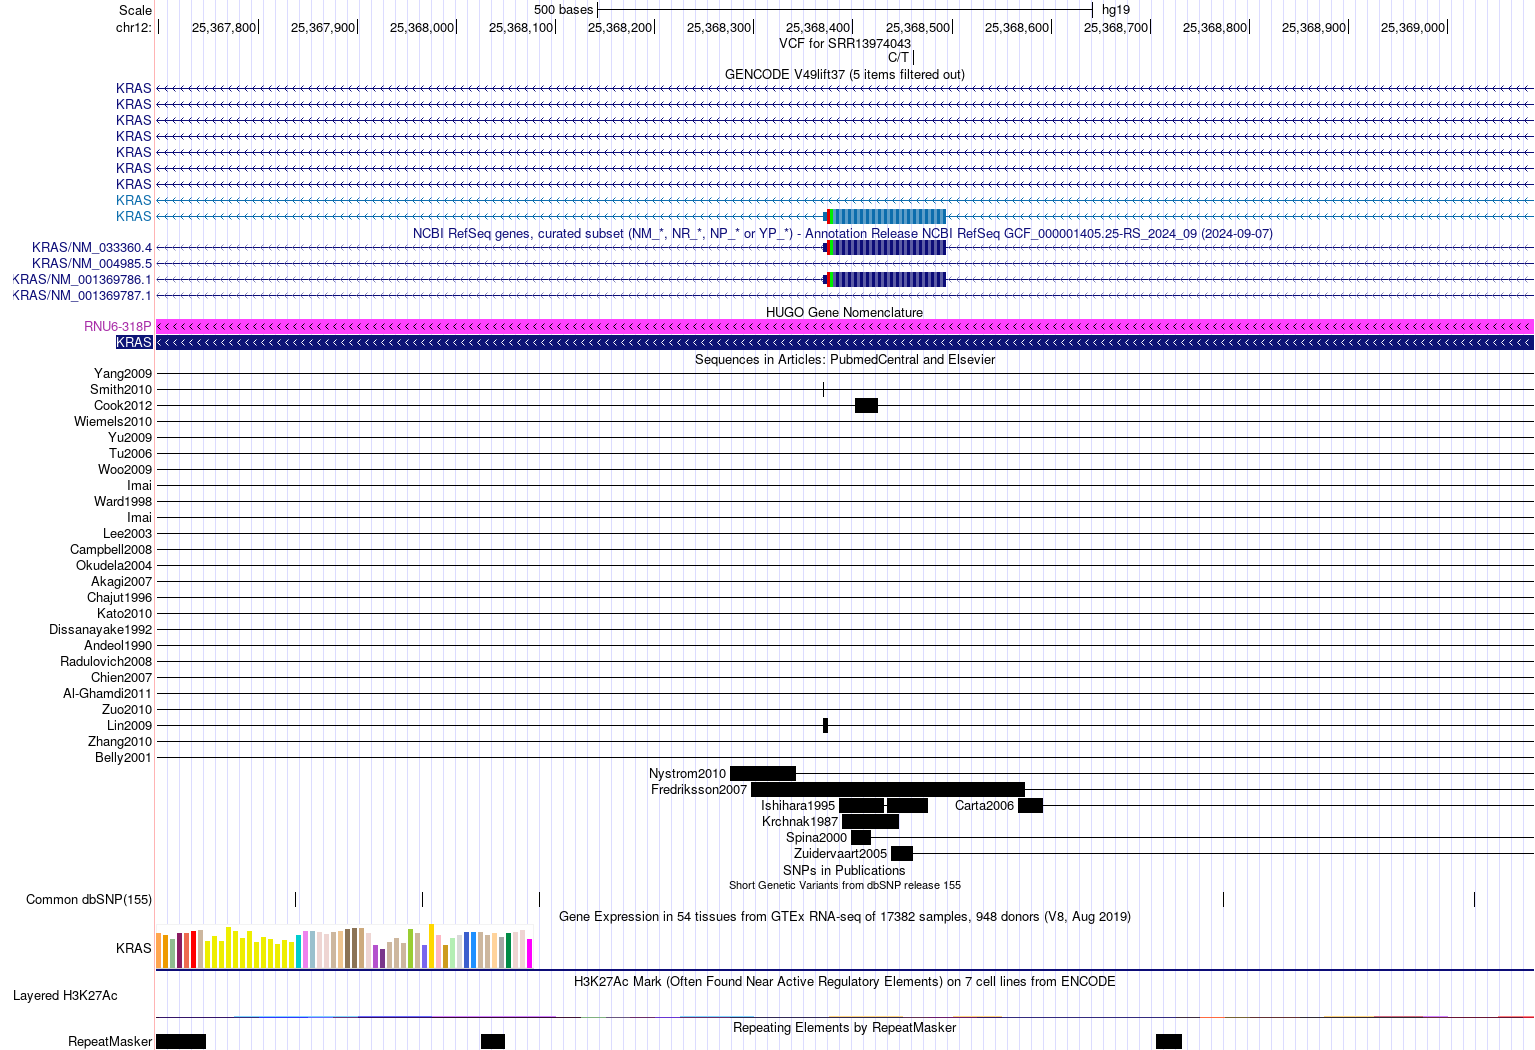

# Final conclusion

Table 2 in Lim et al., 2021 indicates that only 6 patients exhibited the mutations of interest in KRAS. Therefore, I conclude that either the sample SRR13974043 was not from one of them, or the mechanics of the pipeline failed to identify them.

Since the purpose of this exercise is to demonstrate the process, it is not appropriate to implement an exhaustive search through the other samples.  However, in a high performance compute environment, the pipeline would have very efficient throughput.  For the purpose of validating the original authors' results, it may be sufficient and simpler to narrow the sequence comparison only to chromosome 12.

Had the pipeline found missense mutations in the sample, they could be prioritized by relevance according to the literature, or database entries. However, novel discoveries of important residue polymorphisms will undoubtedly arise, and those will have to be intrepreted without the context of prior knowledge.  To justify further research on any previously unknown polymorphic site, it would have to have sufficient statistical association with patients demonstrating the conditions of interest. They could be further categorized by the functional domain in the gene containing the SNP, and especially with regard to the potential for pharmacological intervention.